In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import (
    FunctionTransformer, OneHotEncoder,OrdinalEncoder,
    StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
)
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier



## 1.preparation

In [2]:
#load dataset
df_raw = pd.read_csv('data/raw/alcohol_consumption_raw.csv')

print("Shape of raw dataset:", df_raw.shape)
df_raw.head()


Shape of raw dataset: (991346, 24)


,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1,1,120,...,126,92,17.1,1,1.0,21,35,40,1,Y
1,Male,30,180,80,89.0,0.9,1.2,1,1,130,...,148,121,15.8,1,0.9,20,36,27,3,N
2,Male,40,165,75,91.0,1.2,1.5,1,1,120,...,74,104,15.8,1,0.9,47,32,68,1,N
3,Male,50,175,80,91.0,1.5,1.2,1,1,145,...,104,106,17.6,1,1.1,29,34,18,1,N
4,Male,50,165,60,80.0,1.0,1.2,1,1,138,...,117,104,13.8,1,0.8,19,12,25,1,N


In [3]:
#create index to trace the samples
df_raw['ID'] = df_raw.index
df_raw.set_index('ID', inplace=True)
print(df_raw.index[:5])

Index([0, 1, 2, 3, 4], dtype='int64', name='ID')


## 2.preprocessing

In [4]:
#treat placeholders as missing values
df_raw['waistline'] = df_raw['waistline'].replace(999, np.nan)
df_raw['gamma_GTP'] = df_raw['gamma_GTP'].replace(999, np.nan)

In [ ]:
#construct new features based on domain knowledge

df_newf = df_raw.copy()


df_newf['BMI'] = df_newf['weight'] / ((df_newf['height']/100)**2)
df_newf['pulse_pressure'] = df_newf['SBP'] - df_newf['DBP']
df_newf['AST_ALT_ratio'] = df_newf['SGOT_AST'] / df_newf['SGOT_ALT']

waist_thresh = df_newf['sex'].map({'Male': 90, 'Female': 80})
risk_waist = df_newf['waistline'] > waist_thresh
risk_bp = (df_newf['SBP'] >= 130) | (df_newf['DBP'] >= 85)
risk_tg = df_newf['triglyceride'] >= 150
risk_chole = df_newf['tot_chole'] >= 200
risk_glu = df_newf['BLDS'] >= 100

df_newf['risk_waist']=risk_waist.astype(int)
df_newf['risk_bp']=risk_bp.astype(int)
df_newf['risk_tg']=risk_tg.astype(int)
df_newf['risk_hdl']=risk_chole.astype(int)
df_newf['risk_glu']=risk_glu.astype(int)


df_newf.to_csv('data/smoking_driking_dataset_with_medical_features.csv')
df_newf.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,SMK_stat_type_cd,DRK_YN,BMI,pulse_pressure,AST_ALT_ratio,risk_waist,risk_bp,risk_tg,risk_hdl,risk_glu
ID,,,,,,,,,,,,,,,,,,,,,
0,Male,35,170,75,90.0,1.0,1.0,1,1,120,...,1,Y,25.951557,40,0.600000,0,0,0,0,0
1,Male,30,180,80,89.0,0.9,1.2,1,1,130,...,3,N,24.691358,48,0.555556,0,1,0,1,1
2,Male,40,165,75,91.0,1.2,1.5,1,1,120,...,1,N,27.548209,50,1.468750,1,0,0,0,0
3,Male,50,175,80,91.0,1.5,1.2,1,1,145,...,1,N,26.122449,58,0.852941,1,1,0,1,0
4,Male,50,165,60,80.0,1.0,1.2,1,1,138,...,1,N,22.038567,56,1.583333,0,1,0,0,1


In [6]:
#splitting data and target
X = df_newf.drop('DRK_YN', axis=1)
y = (df_newf['DRK_YN'] == 'Y').astype(int)
y.count

<bound method Series.count of ID
0         1
1         0
2         0
3         0
4         0
         ..
991341    0
991342    0
991343    1
991344    0
991345    1
Name: DRK_YN, Length: 991346, dtype: int64>

In [ ]:
#transformations unrelated to values from the same column

#replace 9.9 in sight with 0 since it indicates blindness
def transform_sight(X):
    df = pd.DataFrame(X, columns=['sight_left', 'sight_right'])
    # replace 9.9 with 0
    df = df.replace(9.9, 0)
    return df

#if there's one ear abnormal then mark as "abnormal hearing"
def transform_hear(X):
    df = pd.DataFrame(X, columns=['hear_left','hear_right'])
    return pd.DataFrame({
        'hear_any_2': ((df['hear_left']==2)|(df['hear_right']==2)).astype(int),
        # 'hear_both_2': ((df['hear_left']==2)&(df['hear_right']==2)).astype(int)
    })

#map the urine value to the median or cutoff value of each bin to better simulate the distribution
def transform_urine(X):
    if hasattr(X, "values"):          
        arr = X.values.flatten()
    else:                             
        arr = np.asarray(X).flatten()
    mapping = {1:5, 2:15, 3:30, 4:100, 5:300, 6:1000}
    mapped = [mapping.get(int(v), np.nan) for v in arr]
    return pd.DataFrame(
        {"urine_protein_mapped": mapped},
        index=getattr(X, "index", None)
    )


In [8]:
#to plug into the pipeline
sight_transformer = FunctionTransformer(transform_sight, validate=False)
hear_transformer = FunctionTransformer(transform_hear, validate=False)
urine_transformer = FunctionTransformer(transform_urine, validate=False)

#transforming the categorical variables
smk_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sex_encoder = OrdinalEncoder()


#combination
cat_transformer = ColumnTransformer([
    ('sight', sight_transformer, ['sight_left','sight_right']),
    ('hear', hear_transformer, ['hear_left','hear_right']),
    ('urine', urine_transformer, ['urine_protein']),
    ('smk', smk_encoder, ['SMK_stat_type_cd']),
    ('sex',sex_encoder, ['sex'])
], remainder='passthrough',verbose_feature_names_out=False ).set_output(transform='pandas')

In [9]:
X_cattf = cat_transformer.fit_transform(X)
X_cattf.count

<bound method DataFrame.count of         sight_left  sight_right  hear_any_2  urine_protein_mapped  \
ID                                                                  
0              1.0          1.0           0                     5   
1              0.9          1.2           0                     5   
2              1.2          1.5           0                     5   
3              1.5          1.2           0                     5   
4              1.0          1.2           0                     5   
...            ...          ...         ...                   ...   
991341         1.5          1.5           0                     5   
991342         1.0          1.5           0                     5   
991343         1.0          0.7           0                     5   
991344         1.5          1.0           0                     5   
991345         1.0          1.5           0                     5   

        SMK_stat_type_cd_1  SMK_stat_type_cd_2  SMK_stat_type_cd_3  s

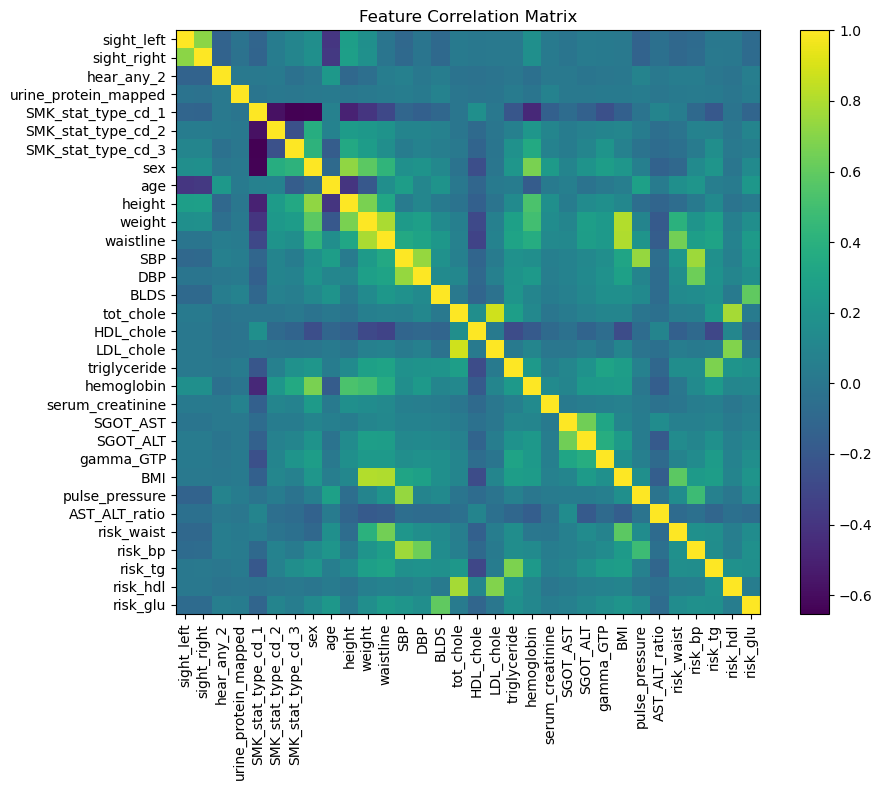

Because correlation coefficient |ρ| > 0.9, features to drop: []
Reduced dataset shape: (991346, 32)


In [11]:

#calculate & plot the correlation
corr_matrix = X_cattf.corr()

plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar(im)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

#drop the columns with too high a correlation
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col].abs() > threshold)]
print("Because correlation coefficient |ρ| > 0.9, features to drop:", to_drop)


df_reduced = X_cattf.drop(columns=to_drop)
print("Reduced dataset shape:", df_reduced.shape)


In [10]:
#split the dataset
from sklearn.model_selection import train_test_split

def split_dataset(X,y,
                  test_size: float = 0.2,
                  val_size: float = None,
                  random_state: int = 1,
                  target: str = 'DRK_YN'
                  ):
    """
    Split a DataFrame into training, testing (and optionally validation) sets.

    Parameters
    ----------
    df : pd.DataFrame
        The full input DataFrame.
    target_col : str
        Name of the target column to predict (e.g., 'DRK_YN').
    test_size : float
        Proportion of the original data to assign to the test set (default 0.2).
    val_size : float or None
        If not None, fraction of the (test + validation) split to allocate to validation.
        For example, val_size=0.5 will split the temp set evenly into validation and test.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    If `val_size` is None:
        X_train, X_test, y_train, y_test
    Otherwise:
        X_train, X_val, X_test, y_train, y_val, y_test
    """

    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )
    y_train = y_train.to_frame(name=target)

    if val_size is not None:
        val_ratio = val_size
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=1 - val_ratio,
            random_state=random_state
        )
        y_val  = y_val.to_frame(name=target)
        y_test = y_test.to_frame(name=target)
        return X_train, X_val, X_test, y_train, y_val, y_test

    X_test, y_test = X_temp, y_temp.to_frame(name=target)
    return X_train, X_test, y_train, y_test


In [11]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X_cattf,y,test_size=0.3,val_size=0.5)


In [17]:
#columns to be non-linearly transformed


skews = X_cattf.skew()        # skew
kurts = X_cattf.kurtosis()    # kurtosis
print(skews)
to_transform = skews[skews.abs() > 1].index.tolist()
to_transform += kurts[kurts > 3].index.tolist()
to_transform = list(set(to_transform))
print("columns to transform:", to_transform)

# print(X_cattf.columns)

sight_left                0.005494
sight_right              -0.022978
hear_any_2                4.395736
urine_protein_mapped     27.231428
SMK_stat_type_cd_1       -0.441157
SMK_stat_type_cd_2        1.697270
SMK_stat_type_cd_3        1.381550
sex                      -0.124281
age                       0.153653
height                   -0.022737
weight                    0.576557
waistline                 0.166376
SBP                       0.482060
DBP                       0.400034
BLDS                      4.617377
tot_chole                 1.556882
HDL_chole               104.577635
LDL_chole                 5.251739
triglyceride              6.529373
hemoglobin               -0.383988
serum_creatinine        111.022058
SGOT_AST                150.491690
SGOT_ALT                 50.038872
gamma_GTP                 6.951555
BMI                       0.491674
pulse_pressure            0.677200
AST_ALT_ratio           572.866875
risk_waist                0.989654
risk_bp             

In [20]:
#deal with missing values
impute_cols = ['gamma_GTP','waistline']
imputer = ColumnTransformer([
    ('imp_KNN', KNNImputer(n_neighbors=5), impute_cols)
], remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')  # Keep other columns unchanged

In [21]:
#nonlinear transformation for attributes with high skewness
nonlinear_cols = ['BLDS', 'HDL_chole', 'triglyceride', 'serum_creatinine', 'SGOT_ALT', 'gamma_GTP','tot_chole', 'AST_ALT_ratio', 'LDL_chole', 'SGOT_AST']
# print(df_newf[nonlinear_cols].dtypes)

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

nonlinear_transformer = ColumnTransformer([
    ('yj', PowerTransformer(method='yeo-johnson'), nonlinear_cols)
], remainder='passthrough',verbose_feature_names_out=False ).set_output(transform='pandas')

In [22]:
#linear transformation
scale_cols = ['sight_left',
 'sight_right',
 'urine_protein_mapped',
 'age',
 'height',
 'weight',
 'waistline',
 'SBP',
 'DBP',
 'BLDS',
 'tot_chole',
 'HDL_chole',
 'LDL_chole',
 'triglyceride',
 'hemoglobin',
 'serum_creatinine',
 'SGOT_AST',
 'SGOT_ALT',
 'gamma_GTP',
 'BMI',
 'pulse_pressure',
 'AST_ALT_ratio']
scaler = ColumnTransformer([
    ('scl_rob',RobustScaler(),scale_cols)
    ],remainder='passthrough',verbose_feature_names_out=False 
).set_output(transform='pandas')

In [23]:
#feature selection
feature_selector = VarianceThreshold(threshold=0.0)
     

In [ ]:
#outlier treatment
from scipy.stats.mstats import winsorize
winsor_col = ['sight_left',
 'sight_right',
 'urine_protein_mapped',
 'age',
 'height',
 'weight',
 'waistline',
 'SBP',
 'DBP',
 'BLDS',
 'tot_chole',
 'HDL_chole',
 'LDL_chole',
 'triglyceride',
 'hemoglobin',
 'serum_creatinine',
 'SGOT_AST',
 'SGOT_ALT',
 'gamma_GTP',
 'BMI',
 'pulse_pressure',
 'AST_ALT_ratio']
def _winsor_df(X, low_t, high_t, columns):
    df = X.copy()
    for col in columns:
        arr = df[col].to_numpy()
        arr_w = winsorize(arr, limits=(low_t, high_t))
        df[col] = np.ma.filled(arr_w, fill_value=np.nan)
    return df  

winsor = FunctionTransformer(
    func=_winsor_df,
    kw_args={'low_t': 0.01, 'high_t': 0.01, 'columns': winsor_col},
    validate=False
)


## 3.model

In [ ]:
pipe = Pipeline([
    ('impute', imputer),
    ('outlier_treatment',winsor),
    ('nonlinear_transform',nonlinear_transformer),
    ('linear_transform',scaler),
    ('feature_selection', feature_selector),
    ('clf',MLPClassifier(max_iter=500, random_state=42
    )  )                  
    ]
).set_output(transform='pandas')


In [ ]:
param_grid = {
    'outlier_treatment__kw_args': [
        {'low_t': lim, 'high_t': lim, 'columns': winsor_col}
        for lim in (0.001,0.005,0.01,0.03,0.05)
    ],

    
    'clf__hidden_layer_sizes': [(50,), (100,),(50,50)],      
    'clf__alpha':                [1e-4, 1e-3],       
    'clf__learning_rate_init':   [1e-3, 1e-2],       
}



## 4.model training&validation&testing

In [ ]:
#training on training set & trying out parameters on validation set
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
from sklearn.metrics    import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from tqdm.auto import tqdm
import time

pos_label = 1

param_list = list(ParameterGrid(param_grid))
#record the performmane of each param combination
records = []


for i, params in enumerate(tqdm(param_list, desc="Hyper-param loop")):
    print(params)
    pipe.set_params(**params)
    t0 = time.time()
    pipe.fit(X_train, y_train)
    print(f"    Train Time: {time.time()-t0:.1f}s")
    yv_pred  = pipe.predict(X_val)
    yv_proba = pipe.predict_proba(X_val)[:,1]
    
    records.append({
        'param_idx':    i,
        **params,
        'accuracy':     accuracy_score(y_val, yv_pred),
        'f1_score':     f1_score(y_val, yv_pred, pos_label=pos_label),
        'roc_auc':      roc_auc_score((y_val==pos_label).astype(int), yv_proba),
        
    })

metrics_df = pd.DataFrame(records)





Hyper-param loop:   0%|          | 0/60 [00:00<?, ?it/s]

{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 95.5s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 81.7s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 114.3s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 76.3s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 76.4s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 144.4s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 143.8s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 142.8s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 141.8s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 148.4s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 212.0s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 167.5s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 131.7s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 111.8s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 116.5s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 230.3s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 137.0s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 136.6s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 174.9s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 162.5s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 228.2s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 271.4s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 243.2s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 129.6s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 183.2s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 157.0s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 143.4s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 159.1s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 149.8s
{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 231.3s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 73.2s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 60.2s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 59.1s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 63.4s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 93.5s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 121.1s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 126.6s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 126.5s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 77.7s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 127.4s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 152.4s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 112.2s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 173.0s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 174.2s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 188.3s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 270.2s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 250.4s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 118.4s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 175.9s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 143.7s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 132.3s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 204.0s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 165.3s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 160.0s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 122.4s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.001, 'high_t': 0.001, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 143.0s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.005, 'high_t': 0.005, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 167.0s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.01, 'high_t': 0.01, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 164.6s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.03, 'high_t': 0.03, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 180.4s
{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.01, 'outlier_treatment__kw_args': {'low_t': 0.05, 'high_t': 0.05, 'columns': ['sight_left', 'sight_right', 'urine_protein_mapped', 'age', 'height', 'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'BMI', 'pulse_pressure', 'AST_ALT_ratio']}}


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    Train Time: 181.2s


In [30]:
#choosing the best param combination
candidates = metrics_df.copy()
pareto_param_idx = []

for _, row in candidates.iterrows():
    acc = row['accuracy']
    f1  = row['f1_score']
    auc = row['roc_auc']
    
    better = candidates[
        (candidates['accuracy'] >= acc) &
        (candidates['roc_auc'] >= auc) &
        (candidates['f1_score']  >= f1)
    ]
    
    if len(better) == 1:
        pareto_param_idx.append(row['param_idx'])

pareto_df = candidates[candidates['param_idx'].isin(pareto_param_idx)]

print("The Pareto-optimal param_idx are:", pareto_param_idx)
print(pareto_df)


The Pareto-optimal param_idx are: [1, 2, 12, 29, 42]
    param_idx  clf__alpha clf__hidden_layer_sizes  clf__learning_rate_init  \
1           1      0.0001                   (50,)                    0.001   
2           2      0.0001                   (50,)                    0.001   
12         12      0.0001                  (100,)                    0.001   
29         29      0.0001                (50, 50)                    0.010   
42         42      0.0010                  (100,)                    0.001   

                           outlier_treatment__kw_args  accuracy  f1_score  \
1   {'low_t': 0.005, 'high_t': 0.005, 'columns': [...  0.739190  0.745233   
2   {'low_t': 0.01, 'high_t': 0.01, 'columns': ['s...  0.739217  0.738871   
12  {'low_t': 0.01, 'high_t': 0.01, 'columns': ['s...  0.739654  0.742343   
29  {'low_t': 0.05, 'high_t': 0.05, 'columns': ['s...  0.737852  0.746029   
42  {'low_t': 0.01, 'high_t': 0.01, 'columns': ['s...  0.739963  0.741500   

     roc_auc  


In [31]:
#secondary filter based on the distance to (1,1,1)
import numpy as np

pareto_df['dist_to_ideal'] = np.sqrt(
    (1 - pareto_df['accuracy'])**2 +
    (1 - pareto_df['f1_score'])**2  +
    (1 - pareto_df['roc_auc'])**2
)

best_row = pareto_df.sort_values('dist_to_ideal', ascending=True).iloc[0]
print(best_row)

param_idx                                                                     1
clf__alpha                                                               0.0001
clf__hidden_layer_sizes                                                   (50,)
clf__learning_rate_init                                                   0.001
outlier_treatment__kw_args    {'low_t': 0.005, 'high_t': 0.005, 'columns': [...
accuracy                                                                0.73919
f1_score                                                               0.745233
roc_auc                                                                0.823052
dist_to_ideal                                                          0.405264
Name: 1, dtype: object


/var/folders/ds/5wct1gj9553bgnft0x7x5tb40000gn/T/ipykernel_32858/1376562781.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pareto_df['dist_to_ideal'] = np.sqrt(


In [ ]:
metrics_df.to_csv('clf_params_summary_60_1.csv')

In [ ]:
#keep the parameters and drop the evaluation metrics
best_params = best_row.filter(regex="__")

param_dict = best_params.to_dict()

pipe.set_params(**param_dict)

/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('impute',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp_KNN', KNNImputer(),
                                                  ['gamma_GTP', 'waistline'])],
                                   verbose_feature_names_out=False)),
                ('outlier_treatment',
                 FunctionTransformer(func=<function _winsor_df at 0x135d71a60>,
                                     kw_args={'columns': ['sight_left',
                                                          'sight_right',
                                                          'urine_protein_mapped',
                                                          'age', 'height',
                                                          'weight', 'waistli...
                                                   'age', 'height', 'weight',
                                                   'waistline', 'SBP', 'DBP',
                                                   'BLDS', 'tot_chole',
                                                   'HDL_chole', 'LDL_chole',
                                                   'triglyceride', 'hemoglobin',
                                                   'serum_creatinine',
                                                   'SGOT_AST', 'SGOT_ALT',
                                                   'gamma_GTP', 'BMI',
                                                   'pulse_pressure',
                                                   'AST_ALT_ratio'])],
                                   verbose_feature_names_out=False)),
                ('feature_selection', VarianceThreshold()),
                ('clf',
                 MLPClassifier(hidden_layer_sizes=(50,), max_iter=500,
                               random_state=42))])

In [39]:
X_tr_va = pd.concat([X_train,X_val])
y_tr_va = pd.concat([y_train, y_val])
X_tr_va.info()

<class 'pandas.core.frame.DataFrame'>
Index: 842644 entries, 326864 to 401122
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   sight_left            842644 non-null  float64
 1   sight_right           842644 non-null  float64
 2   hear_any_2            842644 non-null  int64  
 3   urine_protein_mapped  842644 non-null  int64  
 4   SMK_stat_type_cd_1    842644 non-null  float64
 5   SMK_stat_type_cd_2    842644 non-null  float64
 6   SMK_stat_type_cd_3    842644 non-null  float64
 7   sex                   842644 non-null  float64
 8   age                   842644 non-null  int64  
 9   height                842644 non-null  int64  
 10  weight                842644 non-null  int64  
 11  waistline             842596 non-null  float64
 12  SBP                   842644 non-null  int64  
 13  DBP                   842644 non-null  int64  
 14  BLDS                  842644 non-null  int64  
 15  

In [ ]:
#running the model on testing set

#refit
X_tr_va = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_tr_va = pd.concat([y_train, y_val], axis=0, ignore_index=True)


pipe.fit(X_tr_va,y_tr_va)


yt_true  = y_test.to_numpy().ravel()
yt_pred  = pipe.predict(X_test)
yt_proba = pipe.predict_proba(X_test)[:,1]

tn, fp, fn, tp = confusion_matrix(yt_true, yt_pred, labels=[0,1]).ravel()
acc = accuracy_score(yt_true, yt_pred)
f1  = f1_score(yt_true, yt_pred, pos_label=pos_label)
auc = roc_auc_score((yt_true==pos_label).astype(int), yt_proba)

test_metrics = pd.DataFrame([{
    'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn,
    'accuracy': acc, 'f1_score': f1, 'roc_auc': auc
}])
print("\n=== test_metrics DataFrame ===")
print(test_metrics)

#record the result of each sample
mask_fp   = (yt_true==0) & (yt_pred==1)
mask_fn   = (yt_true==1) & (yt_pred==0)
mask_tp   = (yt_true==1) & (yt_pred==1)
code_test = np.zeros_like(yt_true, dtype=np.uint8)
code_test[mask_fp] = 1
code_test[mask_fn] = 2
code_test[mask_tp] = 3

fname = 'outcome_codes_test.dat'
if os.path.exists(fname):
    os.remove(fname)
codes_test = np.memmap(fname,
    mode='w+',
    dtype=np.uint8,            
    shape=(len(yt_true),))
codes_test[:] = code_test
codes_test.flush()

sample_df_test = X_test.copy()
# sample_df_test['ID']        = sample_df_test.index
sample_df_test['y_true']    = yt_true
sample_df_test['y_pred']    = yt_pred
sample_df_test['y_proba']   = yt_proba
sample_df_test['code']      = code_test
# sample_df_test['param_idx'] = best_idx


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



=== test_metrics DataFrame ===
      TP     FP     FN     TN  accuracy  f1_score   roc_auc
0  55887  20153  18443  54219  0.740447  0.743326  0.823084


In [42]:
sample_df_test.to_csv('sample_summary_60_1.csv')

## 5.result analysis

PermutationExplainer explainer: 201it [01:26,  2.06it/s]                         


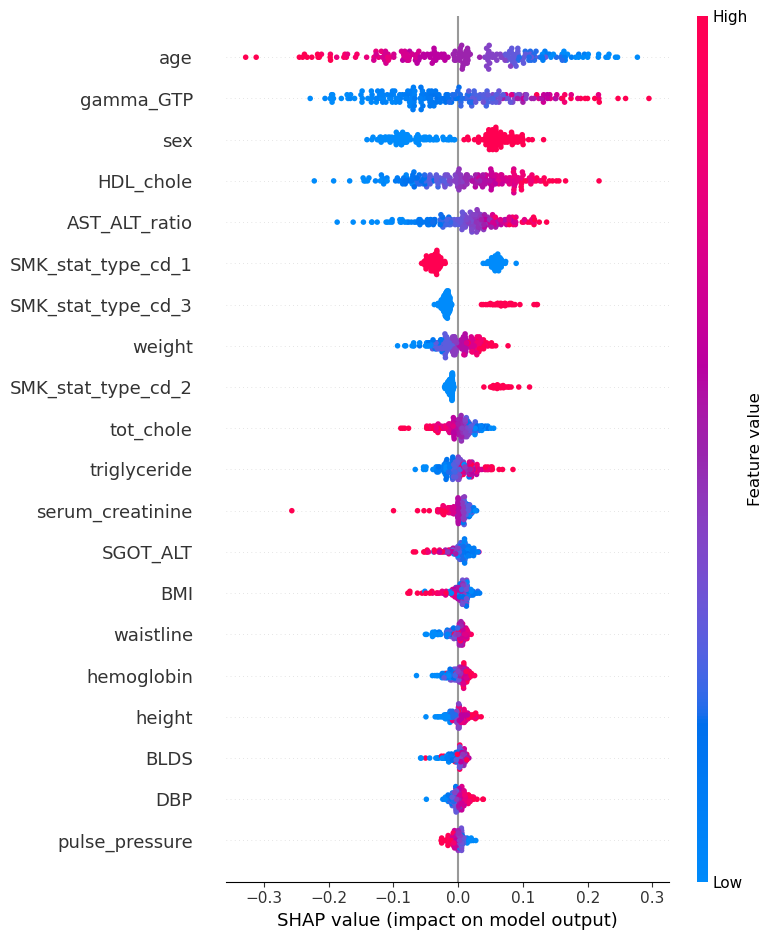

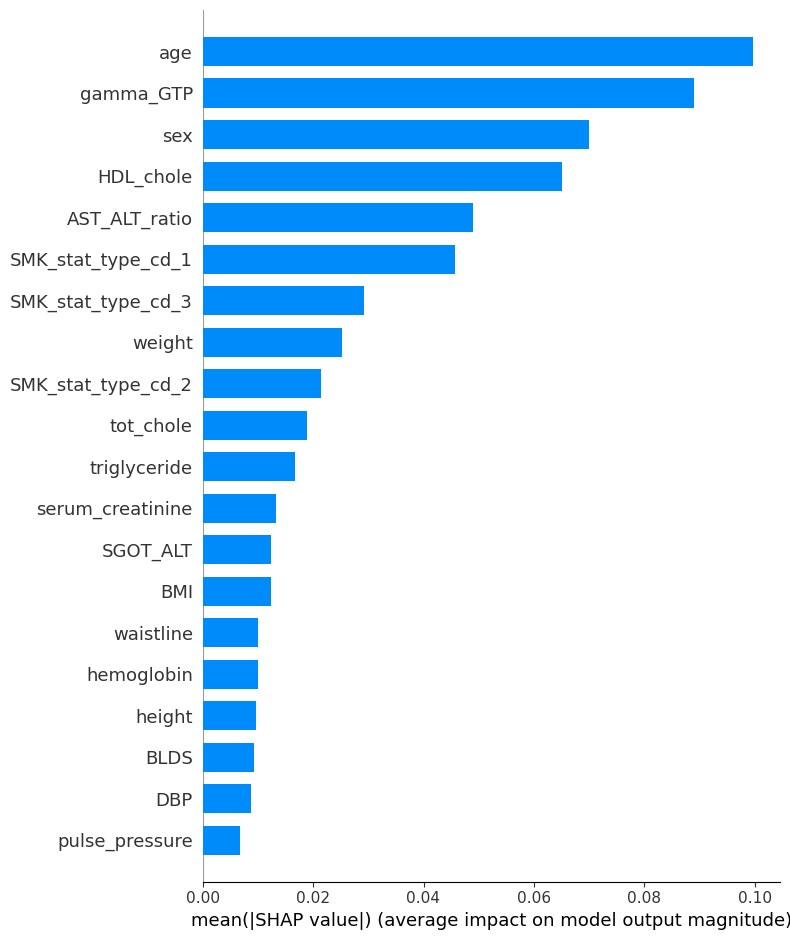

In [ ]:
#shap analysis: feature importance
import shap

#using a small sample to shorten the runtime                                     
X_test_sample = X_test.sample(n=200, random_state=42)

background = shap.sample(X_tr_va, 800, random_state=42)
explainer  = shap.Explainer(pipe.predict_proba, background)

shap_exp   = explainer(X_test_sample)

sv_class1  = shap_exp.values[:, :, 1]

shap.summary_plot(
    sv_class1,              
    X_test_sample,          
    feature_names=X_test_sample.columns
)

shap.summary_plot(
    sv_class1,
    X_test_sample,
    feature_names=X_test_sample.columns,
    plot_type='bar'
)

FN describe():
          sight_left   sight_right    hear_any_2  urine_protein_mapped  \
count  18443.000000  18443.000000  18443.000000          18443.000000   
mean       0.915887      0.915811      0.048094              7.477634   
std        0.328882      0.326415      0.213971             26.661276   
min        0.000000      0.000000      0.000000              5.000000   
25%        0.700000      0.700000      0.000000              5.000000   
50%        0.900000      0.900000      0.000000              5.000000   
75%        1.200000      1.200000      0.000000              5.000000   
max        2.000000      2.000000      1.000000           1000.000000   

       SMK_stat_type_cd_1  SMK_stat_type_cd_2  SMK_stat_type_cd_3  \
count        18443.000000        18443.000000        18443.000000   
mean             0.844331            0.095754            0.059914   
std              0.362551            0.294262            0.237334   
min              0.000000            0.000000     

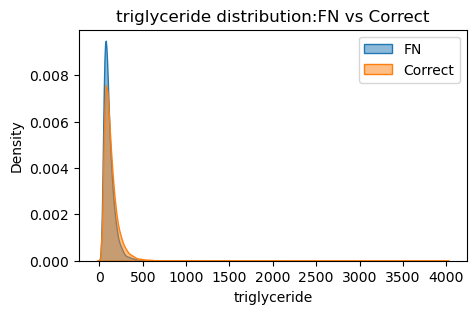

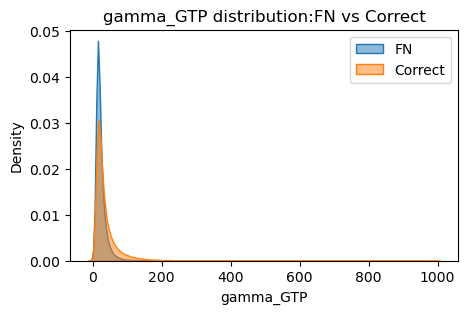

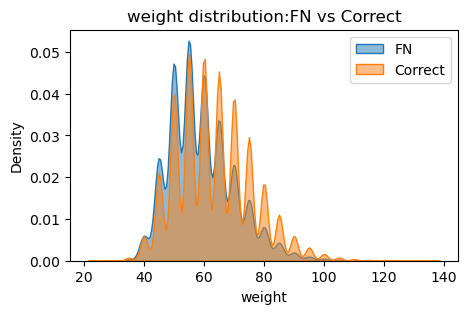

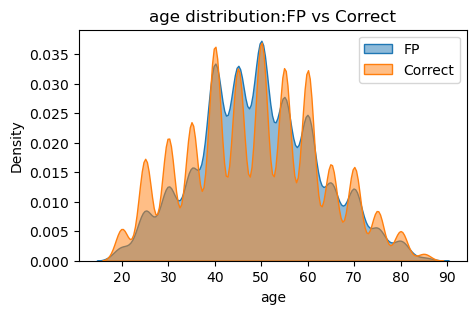

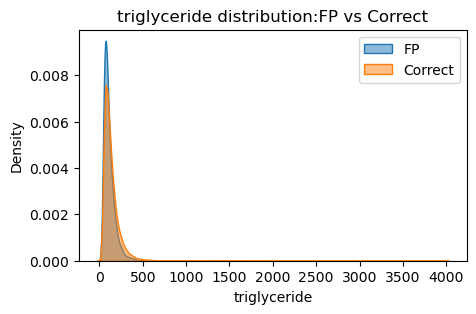

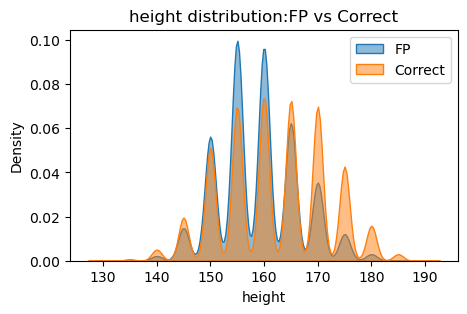

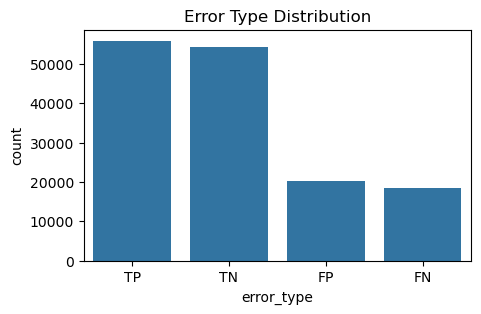

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#the distribution of smaples across tp/fp/tn/fn labels

meta_cols = ['ID','y_true','y_pred','y_proba','code']
feat_cols = [c for c in sample_df_test.columns if c not in meta_cols]

#group by classification labels (fp/fn/correct)
fn_df   = sample_df_test[sample_df_test['code'] == 2][feat_cols]
fp_df   = sample_df_test[sample_df_test['code'] == 1][feat_cols]
corr_df = sample_df_test[sample_df_test['code'].isin([0,3])][feat_cols]

#descriptive 
fn_stats   = fn_df.describe()
fp_stats   = fp_df.describe()
corr_stats = corr_df.describe()

fn_diff = fn_df.mean() - corr_df.mean()
fp_diff = fp_df.mean() - corr_df.mean()

print("FN describe():\n", fn_stats)
print("\nFP describe():\n", fp_stats)
print("\nCorrect describe():\n", corr_stats)
print("\nTop 5 FN mean-diff:\n", fn_diff.abs().sort_values(ascending=False).head(5))
print("\nTop 5 FP mean-diff:\n", fp_diff.abs().sort_values(ascending=False).head(5))

#visualize the distribution of top 3 variables differing from the correct samples in mean
top_fn = fn_diff.abs().sort_values(ascending=False).head(3).index.tolist()
for feat in top_fn:
    plt.figure(figsize=(5,3))
    sns.kdeplot(fn_df[feat], label='FN', fill=True, alpha=0.5)
    sns.kdeplot(corr_df[feat], label='Correct', fill=True, alpha=0.5)
    plt.title(f"{feat} distribution:FN vs Correct")
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

top_fp = fp_diff.abs().sort_values(ascending=False).head(3).index.tolist()
for feat in top_fp:
    plt.figure(figsize=(5,3))
    sns.kdeplot(fn_df[feat], label='FP', fill=True, alpha=0.5)
    sns.kdeplot(corr_df[feat], label='Correct', fill=True, alpha=0.5)
    plt.title(f"{feat} distribution:FP vs Correct")
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

#confusion distribution
type_map = {0:'TN',1:'FP',2:'FN',3:'TP'}
df_vis = sample_df_test.copy()
df_vis['error_type'] = df_vis['code'].map(type_map)

plt.figure(figsize=(5,3))
sns.countplot(data=df_vis, x='error_type', order=['TP','TN','FP','FN'])
plt.title("Error Type Distribution")
plt.show()

